<a href="https://colab.research.google.com/github/emadaghajanzadeh/Out-of-Destribution-Generalization/blob/main/BAI_Out_of_Distribution_Generalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Links

A Recipe for Training Neural Networks: http://karpathy.github.io/2019/04/25/recipe/

WILDS Dataset Homepage: https://worksheets.codalab.org/worksheets/0xb44731cc8e8a4265a20146c3887b6b90

WILDS Dataset Github page: https://github.com/p-lambda/wilds

WILDS Dataset Original Paper: https://arxiv.org/pdf/2012.07421.pdf

RxRx1 Dataset Homepage: https://www.rxrx.ai/rxrx1#the-data

RxRx1 Original Paper: https://aiforsocialgood.github.io/iclr2019/accepted/track1/pdfs/30_aisg_iclr2019.pdf

# Initial Config

In [1]:
!pip install wilds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 4.5 MB/s 
     |████████████████████████████████| 3.2 MB 11.0 MB/s 
     |████████████████████████████████| 78 kB 5.1 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7047 sha256=92a8861df2dd1332ffb3ee909948e30a703f49e49e1b6495d0ffa88f8664f699
  Stored in directory: /root/.cache/pip/wheels/6a/33/c4/0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built littleutils
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [2]:
!python -c "import wilds; print(wilds.__version__)"
# This should print "2.0.0". If it doesn't, update by running:
!pip install -U wilds

2.0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[link text](https://)# Import Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader

# Load the full dataset, and download it if necessary (About 17 Min)
dataset = get_dataset(dataset="rxrx1", download=True)

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


  0%|          | 0/7413123845 [00:00<?, ?Byte/s]

Extracting data/rxrx1_v1.0/archive.tar.gz to data/rxrx1_v1.0

It took 17.87 minutes to download and uncompress the dataset.



# Dataset Inspection

##Understanding Data Formation

In [2]:
import torchvision.transforms as transforms
# Consider changing the resize function parameter in case of computational difficualties (Defaul size is (448, 448))
data_size = (128, 128)
train_data = dataset.get_subset(
    "train",
    transform=transforms.Compose(
        [transforms.Resize(data_size), transforms.ToTensor()]
    ),
)

In [3]:
batch_size_train = 512
train_loader = get_train_loader("standard", train_data, batch_size=batch_size_train)
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [4]:
def infoExtractor(batchSize, data_loader, dataType):
  firstBatch = next(iter(data_loader))
  print(f"Information on {dataType} \
          \nNumber of Batches: {len(data_loader)} \
          \nSize of Each Batch: {batchSize}    \
          \nTotal Amount of Data: {len(data_loader)* batchSize} \n"
        )
  print(f"Each batch has the following shape: {len(firstBatch), firstBatch[0].shape}")   #Which means (?, Batch size, Number of channels, width, height)
  for i in range(len(firstBatch)):
    print(f"The shape of Batch[{i}] is: {firstBatch[i].shape}")

In [5]:
infoExtractor(batch_size_train, train_loader, "Training Data")
# Therefore My guess is that (x, y, metadata)

Information on Training Data           
Number of Batches: 80           
Size of Each Batch: 512              
Total Amount of Data: 40960 

Each batch has the following shape: (3, torch.Size([512, 3, 128, 128]))
The shape of Batch[0] is: torch.Size([512, 3, 128, 128])
The shape of Batch[1] is: torch.Size([512])
The shape of Batch[2] is: torch.Size([512, 7])


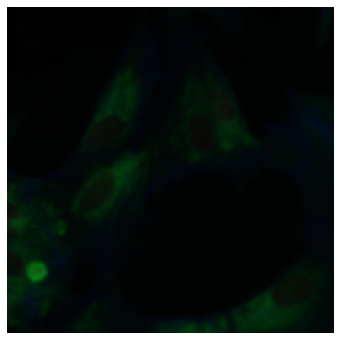

In [6]:
# Select a random data inside the selected batch
firstBatch = next(iter(train_loader))
idx = np.random.randint(batch_size_train)
img = firstBatch[0][idx]
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(np.transpose(img))

## Checking Numbers of Data and Importing Val, In, OOD data

####Validation (OOD):

In [7]:
val_data = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.Resize(data_size), transforms.ToTensor()]
    ),
)

In [8]:
batch_size_val = batch_size_train
val_loader = get_train_loader("standard", val_data, batch_size=batch_size_val)
print(type(val_loader))
infoExtractor(batch_size_val, val_loader, "Validation Data")

<class 'torch.utils.data.dataloader.DataLoader'>
Information on Validation Data           
Number of Batches: 20           
Size of Each Batch: 512              
Total Amount of Data: 10240 

Each batch has the following shape: (3, torch.Size([512, 3, 128, 128]))
The shape of Batch[0] is: torch.Size([512, 3, 128, 128])
The shape of Batch[1] is: torch.Size([512])
The shape of Batch[2] is: torch.Size([512, 7])


####Test (ID):

In [9]:
id_test_data = dataset.get_subset(
    "id_test",
    transform=transforms.Compose(
        [transforms.Resize(data_size), transforms.ToTensor()]
    ),
)

In [10]:
batch_size_id_test = batch_size_train
id_test_loader = get_train_loader("standard", id_test_data, batch_size=batch_size_id_test)
print(type(id_test_loader))
infoExtractor(batch_size_id_test, id_test_loader, "In-Distribution Test Data")

<class 'torch.utils.data.dataloader.DataLoader'>
Information on In-Distribution Test Data           
Number of Batches: 80           
Size of Each Batch: 512              
Total Amount of Data: 40960 

Each batch has the following shape: (3, torch.Size([512, 3, 128, 128]))
The shape of Batch[0] is: torch.Size([512, 3, 128, 128])
The shape of Batch[1] is: torch.Size([512])
The shape of Batch[2] is: torch.Size([512, 7])


####Test (OOD):

In [11]:
# Based on the original annotation used, this data named test_data not ood_test_data
test_data = dataset.get_subset(
    "test",
    transform=transforms.Compose(
        [transforms.Resize(data_size), transforms.ToTensor()]
    ),
)

In [12]:
batch_size_test = batch_size_train
test_loader = get_train_loader("standard", test_data, batch_size=batch_size_test)
print(type(test_loader))
infoExtractor(batch_size_test, test_loader, "Test Data")

<class 'torch.utils.data.dataloader.DataLoader'>
Information on Test Data           
Number of Batches: 68           
Size of Each Batch: 512              
Total Amount of Data: 34816 

Each batch has the following shape: (3, torch.Size([512, 3, 128, 128]))
The shape of Batch[0] is: torch.Size([512, 3, 128, 128])
The shape of Batch[1] is: torch.Size([512])
The shape of Batch[2] is: torch.Size([512, 7])


# Model Defnition

In [ ]:
# Simple model
# Code from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(5, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1139)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training and Validation

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
metrics = []  #It is going to be filled as (train_loss, val_loss, id_loss, ood_loss)

In [ ]:
# Only for showing the progress bar
import tensorflow as tf


n_epochs = 2
n_batches_used_train = 10
# n_batches_used = len(train_loader)

n_batches_used_val = 10
losses_train = []
losses_val = []
for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')
    running_loss = 0
    pbar = tf.keras.utils.Progbar(target=n_batches_used_train)
    #Training
    for i, batch in enumerate(train_loader, 0):
        if i == n_batches_used_train:
          break
        x, y, metadata = batch

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        pbar.update(i, values=[("loss",loss.item())])
    losses_train.append(running_loss/n_batches_used_train)

    #Validation
    with torch.no_grad():
      val_loss = 0
      for i, batch in enumerate(val_loader):
          if i==n_batches_used_val:
            break
          x, y, metadata = batch
          outputs = net(x)
          val_loss += criterion(outputs, y)

    losses_val.append(val_loss.item()/n_batches_used_train)

    #Because we need to overwrite on the previous line forr training, you should pass "n_batches_used_train"  as the first arg.
    pbar.update(n_batches_used_train, values=[('val_loss', val_loss.item()/n_batches_used_val)])

metrics.append(losses_train[-1])
metrics.append(losses_val[-1])
print('Finished Training')

Epoch 1/2
10/10 [==============================] - 64s 6s/step - loss: 7.0464 - val_loss: 7.0418
Epoch 2/2
10/10 [==============================] - 61s 6s/step - loss: 7.0411 - val_loss: 7.0433
Finished Training


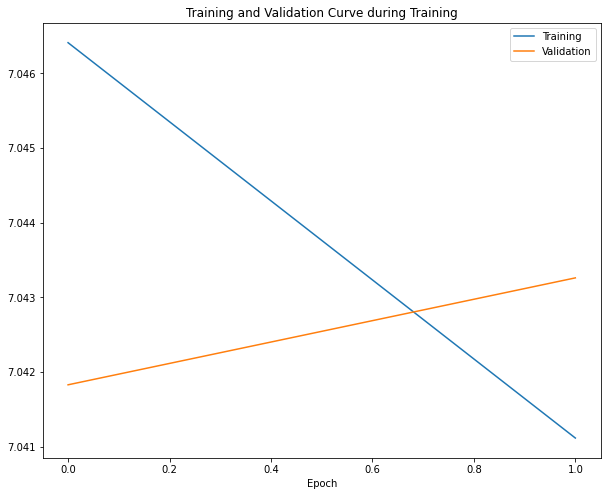

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.xlabel("Epoch")
plt.title("Training and Validation Curve during Training")
plt.plot(losses_train)
plt.plot(losses_val)
plt.legend(["Training", "Validation"])

# ID Test

In [ ]:
n_batches_used_id = 10
losses_id = []
#Validation
with torch.no_grad():
  id_loss = 0
  for i, batch in enumerate(id_test_loader):
      if i % (n_batches_used_id/3) == 0:
        print(f"Progressing ... {i}/{n_batches_used_id}")
      pbar = tf.keras.utils.Progbar(target=n_batches_used_id)
      if i==n_batches_used_id:
        break
      x, y, metadata = batch
      outputs = net(x)
      id_loss += criterion(outputs, y)
print(id_loss/n_batches_used_id)
metrics.append(id_loss/n_batches_used_id)

Progressing ... 0/10
tensor(7.0445)


In [ ]:
# Later should be replaced by: dataset.eval(all_y_pred, all_y_true, all_metadata)
# This function is provided by the authours

# OOD Test

In [ ]:
# To be Completed ...
n_batches_used_ood = 10
losses_ood = []
#Validation
with torch.no_grad():
  ood_loss = 0
  for i, batch in enumerate(test_data):
      if i % (n_batches_used_ood/3) == 0:
        print(f"Progressing ... {i}/{n_batches_used_ood}")
      pbar = tf.keras.utils.Progbar(target=n_batches_used_ood)
      if i==n_batches_used_ood:
        break
      x, y, metadata = batch
      outputs = net(x)
      id_loss += criterion(outputs, y)
print(id_loss/n_batches_used_ood)
metrics.append(id_loss/n_batches_used_ood)

# Deep CORAL

In [ ]:
# Code from https://github.com/p-lambda/wilds/blob/main/examples/algorithms/deepCORAL.py
import torch
from models.initializer import initialize_model
from algorithms.single_model_algorithm import SingleModelAlgorithm
from wilds.common.utils import split_into_groups
from utils import concat_input

class DeepCORAL(SingleModelAlgorithm):
    """
    Deep CORAL.
    This algorithm was originally proposed as an unsupervised domain adaptation algorithm.
    Original paper:
        @inproceedings{sun2016deep,
          title={Deep CORAL: Correlation alignment for deep domain adaptation},
          author={Sun, Baochen and Saenko, Kate},
          booktitle={European Conference on Computer Vision},
          pages={443--450},
          year={2016},
          organization={Springer}
        }
    The original CORAL loss is the distance between second-order statistics (covariances)
    of the source and target features.
    The CORAL penalty function below is adapted from DomainBed's implementation:
    https://github.com/facebookresearch/DomainBed/blob/1a61f7ff44b02776619803a1dd12f952528ca531/domainbed/algorithms.py#L539
    """
    def __init__(self, config, d_out, grouper, loss, metric, n_train_steps):
        # check config
        assert config.train_loader == 'group'
        assert config.uniform_over_groups
        assert config.distinct_groups
        # initialize models
        featurizer, classifier = initialize_model(config, d_out=d_out, is_featurizer=True)
        featurizer = featurizer.to(config.device)
        classifier = classifier.to(config.device)
        model = torch.nn.Sequential(featurizer, classifier)
        # initialize module
        super().__init__(
            config=config,
            model=model,
            grouper=grouper,
            loss=loss,
            metric=metric,
            n_train_steps=n_train_steps,
        )
        # algorithm hyperparameters
        self.penalty_weight = config.coral_penalty_weight
        # additional logging
        self.logged_fields.append('penalty')
        # set model components
        self.featurizer = featurizer
        self.classifier = classifier

    def coral_penalty(self, x, y):
        if x.dim() > 2:
            # featurizers output Tensors of size (batch_size, ..., feature dimensionality).
            # we flatten to Tensors of size (*, feature dimensionality)
            x = x.view(-1, x.size(-1))
            y = y.view(-1, y.size(-1))

        mean_x = x.mean(0, keepdim=True)
        mean_y = y.mean(0, keepdim=True)
        cent_x = x - mean_x
        cent_y = y - mean_y
        cova_x = (cent_x.t() @ cent_x) / (len(x) - 1)
        cova_y = (cent_y.t() @ cent_y) / (len(y) - 1)

        mean_diff = (mean_x - mean_y).pow(2).mean()
        cova_diff = (cova_x - cova_y).pow(2).mean()

        return mean_diff + cova_diff

    def process_batch(self, batch, unlabeled_batch=None):
        """
        Overrides single_model_algorithm.process_batch().
        Args:
            - batch (tuple of Tensors): a batch of data yielded by data loaders
            - unlabeled_batch (tuple of Tensors or None): a batch of data yielded by unlabeled data loader
        Output:
            - results (dictionary): information about the batch
                - y_true (Tensor): ground truth labels for batch
                - g (Tensor): groups for batch
                - metadata (Tensor): metadata for batch
                - unlabeled_g (Tensor): groups for unlabeled batch
                - features (Tensor): featurizer output for batch and unlabeled batch
                - y_pred (Tensor): full model output for batch and unlabeled batch
        """
        # forward pass
        x, y_true, metadata = batch
        y_true = y_true.to(self.device)
        g = self.grouper.metadata_to_group(metadata).to(self.device)

        results = {
            'g': g,
            'y_true': y_true,
            'metadata': metadata,
        }

        if unlabeled_batch is not None:
            unlabeled_x, unlabeled_metadata = unlabeled_batch
            x = concat_input(x, unlabeled_x)
            unlabeled_g = self.grouper.metadata_to_group(unlabeled_metadata).to(self.device)
            results['unlabeled_g'] = unlabeled_g

        x = x.to(self.device)
        features = self.featurizer(x)
        outputs = self.classifier(features)
        y_pred = outputs[: len(y_true)]

        results['features'] = features
        results['y_pred'] = y_pred
        return results

    def objective(self, results):
        if self.is_training:
            features = results.pop('features')

            # Split into groups
            groups = concat_input(results['g'], results['unlabeled_g']) if 'unlabeled_g' in results else results['g']
            unique_groups, group_indices, _ = split_into_groups(groups)
            n_groups_per_batch = unique_groups.numel()

            # Compute penalty - perform pairwise comparisons between features of all the groups
            penalty = torch.zeros(1, device=self.device)
            for i_group in range(n_groups_per_batch):
                for j_group in range(i_group+1, n_groups_per_batch):
                    penalty += self.coral_penalty(features[group_indices[i_group]], features[group_indices[j_group]])
            if n_groups_per_batch > 1:
                penalty /= (n_groups_per_batch * (n_groups_per_batch-1) / 2) # get the mean penalty
        else:
            penalty = 0.

        self.save_metric_for_logging(results, 'penalty', penalty)
        avg_loss = self.loss.compute(results['y_pred'], results['y_true'], return_dict=False)
        return avg_loss + penalty * self.penalty_weight

In [ ]:
import copy
import torch
from tqdm import tqdm
import math

from configs.supported import process_outputs_functions, process_pseudolabels_functions
from utils import save_model, save_pred, get_pred_prefix, get_model_prefix, collate_list, detach_and_clone, InfiniteDataIterator

def run_epoch(algorithm, dataset, general_logger, epoch, config, train, unlabeled_dataset=None):
    if dataset['verbose']:
        general_logger.write(f"\n{dataset['name']}:\n")

    if train:
        algorithm.train()
        torch.set_grad_enabled(True)
    else:
        algorithm.eval()
        torch.set_grad_enabled(False)

    # Not preallocating memory is slower
    # but makes it easier to handle different types of data loaders
    # (which might not return exactly the same number of examples per epoch)
    epoch_y_true = []
    epoch_y_pred = []
    epoch_metadata = []

    # Assert that data loaders are defined for the datasets
    assert 'loader' in dataset, "A data loader must be defined for the dataset."
    if unlabeled_dataset:
        assert 'loader' in unlabeled_dataset, "A data loader must be defined for the dataset."

    batches = dataset['loader']
    if config.progress_bar:
        batches = tqdm(batches)
    last_batch_idx = len(batches)-1
    
    if unlabeled_dataset:
        unlabeled_data_iterator = InfiniteDataIterator(unlabeled_dataset['loader'])

    # Using enumerate(iterator) can sometimes leak memory in some environments (!)
    # so we manually increment batch_idx
    batch_idx = 0
    for labeled_batch in batches:
        if train:
            if unlabeled_dataset:
                unlabeled_batch = next(unlabeled_data_iterator)
                batch_results = algorithm.update(labeled_batch, unlabeled_batch, is_epoch_end=(batch_idx==last_batch_idx))
            else:
                batch_results = algorithm.update(labeled_batch, is_epoch_end=(batch_idx==last_batch_idx))
        else:
            batch_results = algorithm.evaluate(labeled_batch)

        # These tensors are already detached, but we need to clone them again
        # Otherwise they don't get garbage collected properly in some versions
        # The extra detach is just for safety
        # (they should already be detached in batch_results)
        epoch_y_true.append(detach_and_clone(batch_results['y_true']))
        y_pred = detach_and_clone(batch_results['y_pred'])
        if config.process_outputs_function is not None:
            y_pred = process_outputs_functions[config.process_outputs_function](y_pred)
        epoch_y_pred.append(y_pred)
        epoch_metadata.append(detach_and_clone(batch_results['metadata']))

        if train: 
            effective_batch_idx = (batch_idx + 1) / config.gradient_accumulation_steps
        else: 
            effective_batch_idx = batch_idx + 1

        if train and effective_batch_idx % config.log_every==0:
            log_results(algorithm, dataset, general_logger, epoch, math.ceil(effective_batch_idx))

        batch_idx += 1

    epoch_y_pred = collate_list(epoch_y_pred)
    epoch_y_true = collate_list(epoch_y_true)
    epoch_metadata = collate_list(epoch_metadata)

    results, results_str = dataset['dataset'].eval(
        epoch_y_pred,
        epoch_y_true,
        epoch_metadata)

    if config.scheduler_metric_split==dataset['split']:
        algorithm.step_schedulers(
            is_epoch=True,
            metrics=results,
            log_access=(not train))

    # log after updating the scheduler in case it needs to access the internal logs
    log_results(algorithm, dataset, general_logger, epoch, math.ceil(effective_batch_idx))

    results['epoch'] = epoch
    dataset['eval_logger'].log(results)
    if dataset['verbose']:
        general_logger.write('Epoch eval:\n')
        general_logger.write(results_str)

    return results, epoch_y_pred


def train(algorithm, datasets, general_logger, config, epoch_offset, best_val_metric, unlabeled_dataset=None):
    """
    Train loop that, each epoch:
        - Steps an algorithm on the datasets['train'] split and the unlabeled split
        - Evaluates the algorithm on the datasets['val'] split
        - Saves models / preds with frequency according to the configs
        - Evaluates on any other specified splits in the configs
    Assumes that the datasets dict contains labeled data.
    """
    for epoch in range(epoch_offset, config.n_epochs):
        general_logger.write('\nEpoch [%d]:\n' % epoch)

        # First run training
        run_epoch(algorithm, datasets['train'], general_logger, epoch, config, train=True, unlabeled_dataset=unlabeled_dataset)

        # Then run val
        val_results, y_pred = run_epoch(algorithm, datasets['val'], general_logger, epoch, config, train=False)
        curr_val_metric = val_results[config.val_metric]
        general_logger.write(f'Validation {config.val_metric}: {curr_val_metric:.3f}\n')

        if best_val_metric is None:
            is_best = True
        else:
            if config.val_metric_decreasing:
                is_best = curr_val_metric < best_val_metric
            else:
                is_best = curr_val_metric > best_val_metric
        if is_best:
            best_val_metric = curr_val_metric
            general_logger.write(f'Epoch {epoch} has the best validation performance so far.\n')

        save_model_if_needed(algorithm, datasets['val'], epoch, config, is_best, best_val_metric)
        save_pred_if_needed(y_pred, datasets['val'], epoch, config, is_best)

        # Then run everything else
        if config.evaluate_all_splits:
            additional_splits = [split for split in datasets.keys() if split not in ['train','val']]
        else:
            additional_splits = config.eval_splits
        for split in additional_splits:
            _, y_pred = run_epoch(algorithm, datasets[split], general_logger, epoch, config, train=False)
            save_pred_if_needed(y_pred, datasets[split], epoch, config, is_best)

        general_logger.write('\n')


def evaluate(algorithm, datasets, epoch, general_logger, config, is_best):
    algorithm.eval()
    torch.set_grad_enabled(False)
    for split, dataset in datasets.items():
        if (not config.evaluate_all_splits) and (split not in config.eval_splits):
            continue
        epoch_y_true = []
        epoch_y_pred = []
        epoch_metadata = []
        iterator = tqdm(dataset['loader']) if config.progress_bar else dataset['loader']
        for batch in iterator:
            batch_results = algorithm.evaluate(batch)
            epoch_y_true.append(detach_and_clone(batch_results['y_true']))
            y_pred = detach_and_clone(batch_results['y_pred'])
            if config.process_outputs_function is not None:
                y_pred = process_outputs_functions[config.process_outputs_function](y_pred)
            epoch_y_pred.append(y_pred)
            epoch_metadata.append(detach_and_clone(batch_results['metadata']))

        epoch_y_pred = collate_list(epoch_y_pred)
        epoch_y_true = collate_list(epoch_y_true)
        epoch_metadata = collate_list(epoch_metadata)
        results, results_str = dataset['dataset'].eval(
            epoch_y_pred,
            epoch_y_true,
            epoch_metadata)

        results['epoch'] = epoch
        dataset['eval_logger'].log(results)
        general_logger.write(f'Eval split {split} at epoch {epoch}:\n')
        general_logger.write(results_str)

        # Skip saving train preds, since the train loader generally shuffles the data
        if split != 'train':
            save_pred_if_needed(epoch_y_pred, dataset, epoch, config, is_best, force_save=True)

def infer_predictions(model, loader, config):
    """
    Simple inference loop that performs inference using a model (not algorithm) and returns model outputs.
    Compatible with both labeled and unlabeled WILDS datasets.
    """
    model.eval()
    y_pred = []
    iterator = tqdm(loader) if config.progress_bar else loader
    for batch in iterator:
        x = batch[0]
        x = x.to(config.device)
        with torch.no_grad(): 
            output = model(x)
            if not config.soft_pseudolabels and config.process_pseudolabels_function is not None:
                _, output, _, _ = process_pseudolabels_functions[config.process_pseudolabels_function](
                    output,
                    confidence_threshold=config.self_training_threshold if config.dataset == 'globalwheat' else 0
                )
            elif config.soft_pseudolabels:
                output = torch.nn.functional.softmax(output, dim=1)
        if isinstance(output, list):
            y_pred.extend(detach_and_clone(output))
        else:
            y_pred.append(detach_and_clone(output))

    return torch.cat(y_pred, 0) if torch.is_tensor(y_pred[0]) else y_pred

def log_results(algorithm, dataset, general_logger, epoch, effective_batch_idx):
    if algorithm.has_log:
        log = algorithm.get_log()
        log['epoch'] = epoch
        log['batch'] = effective_batch_idx
        dataset['algo_logger'].log(log)
        if dataset['verbose']:
            general_logger.write(algorithm.get_pretty_log_str())
        algorithm.reset_log()


def save_pred_if_needed(y_pred, dataset, epoch, config, is_best, force_save=False):
    if config.save_pred:
        prefix = get_pred_prefix(dataset, config)
        if force_save or (config.save_step is not None and (epoch + 1) % config.save_step == 0):
            save_pred(y_pred, prefix + f'epoch:{epoch}_pred')
        if (not force_save) and config.save_last:
            save_pred(y_pred, prefix + f'epoch:last_pred')
        if config.save_best and is_best:
            save_pred(y_pred, prefix + f'epoch:best_pred')


def save_model_if_needed(algorithm, dataset, epoch, config, is_best, best_val_metric):
    prefix = get_model_prefix(dataset, config)
    if config.save_step is not None and (epoch + 1) % config.save_step == 0:
        save_model(algorithm, epoch, best_val_metric, prefix + f'epoch:{epoch}_model.pth')
    if config.save_last:
        save_model(algorithm, epoch, best_val_metric, prefix + 'epoch:last_model.pth')
    if config.save_best and is_best:
        save_model(algorithm, epoch, best_val_metric, prefix + 'epoch:best_model.pth')


# Scripts

In [19]:
!git clone https://github.com/p-lambda/wilds
!cd wilds
!pip install -e .

Cloning into 'wilds'...
remote: Enumerating objects: 7154, done.
remote: Counting objects: 100% (1982/1982), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 7154 (delta 1891), reused 1807 (delta 1803), pack-reused 5172
Receiving objects: 100% (7154/7154), 1.36 MiB | 7.76 MiB/s, done.
Resolving deltas: 100% (5359/5359), done.
ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: /content


In [21]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.9 MB/s 
     |████████████████████████████████| 7.6 MB 60.9 MB/s 
     |████████████████████████████████| 182 kB 80.7 MB/s 


In [22]:
!git clone "https://github.com/NVIDIA/apex"
!cd apex
!git checkout 4a1aa97e31ca87514e17c3cd3bbc03f4204579d0
!python setup.py install --cuda_ext

!python -c 'import apex; from apex.parallel import LARC' # should run and return nothing
!python -c 'import apex; from apex.parallel import SyncBatchNorm; print(SyncBatchNorm.__module__)' # should run and return apex.parallel.optimized_sync_batchnorm

Cloning into 'apex'...
remote: Enumerating objects: 10667, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 10667 (delta 107), reused 120 (delta 67), pack-reused 10478
Receiving objects: 100% (10667/10667), 15.18 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (7334/7334), done.
fatal: not a git repository (or any of the parent directories): .git
python3: can't open file 'setup.py': [Errno 2] No such file or directory
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'apex.parallel'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'apex.parallel'


In [24]:
!pip install torch-scatter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 8.6 MB/s 
  Created wheel for torch-scatter: filename=torch_scatter-2.1.0-cp38-cp38-linux_x86_64.whl size=3062830 sha256=d396331dc515e5c4e39e82a94d4c81d25ea3f4b366dbd1d19b9dcf7b81f60305
  Stored in directory: /root/.cache/pip/wheels/41/7f/4f/cf072bea3b6efe4561de2db3603ebbd8718c134c24caab8281
Successfully built torch-scatter


In [ ]:
!python wilds/examples/run_expt.py --dataset rxrx1 --algorithm deepCORAL --root_dir data

Dataset: rxrx1
Algorithm: deepCORAL
Root dir: data
Split scheme: official
Dataset kwargs: {}
Download: False
Frac: 1.0
Version: None
Unlabeled split: None
Unlabeled version: None
Use unlabeled y: False
Loader kwargs: {'num_workers': 4, 'pin_memory': True}
Unlabeled loader kwargs: {'num_workers': 8, 'pin_memory': True}
Train loader: group
Uniform over groups: True
Distinct groups: True
N groups per batch: 9
Unlabeled n groups per batch: None
Batch size: 72
Unlabeled batch size: None
Eval loader: standard
Gradient accumulation steps: 1
Model: resnet50
Model kwargs: {'pretrained': True}
Noisystudent add dropout: None
Noisystudent dropout rate: None
Pretrained model path: None
Load featurizer only: False
Teacher model path: None
Transform: rxrx1
Additional train transform: randaugment
Target resolution: (256, 256)
Resize scale: None
Max token length: None
Randaugment n: 2
Loss function: cross_entropy
Loss kwargs: {}
Groupby fields: ['experiment']
Group dro step size: None
Coral penalty wei